## Libraries Import

In [41]:
## Imports
import os 
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from scipy.stats import mode
import copy
from skimage.feature import graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

## Reading Image Dataset

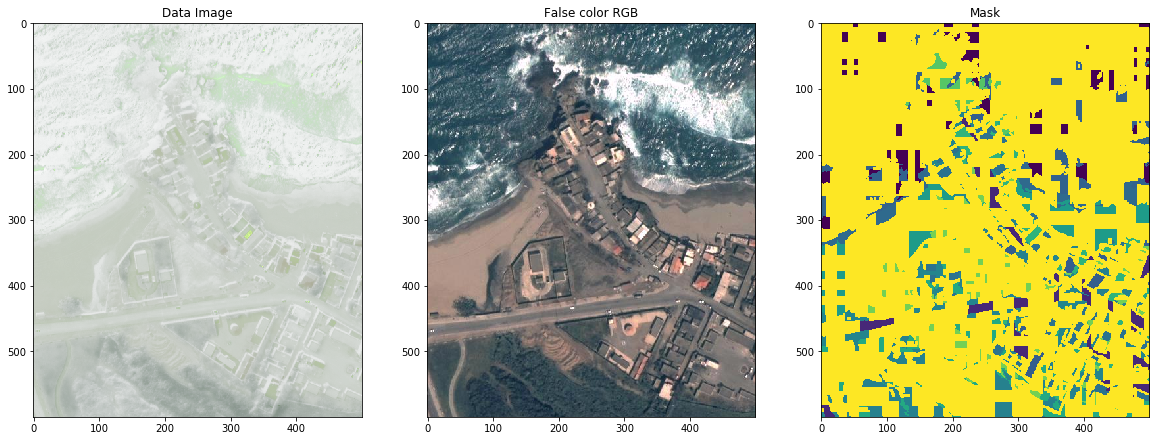

In [22]:
# Reading all data and retrieving labels
data_path = "Boumerdes_dataset"
ids = "Boumerdes"
ids_false_color = "Boumerdes_false_color"
ids_mask = "gt"

original_image_path = os.path.join(data_path, ids) + ".tif"
image_false_color_path = os.path.join(data_path, ids_false_color) + ".jpeg"
mask_path = os.path.join(data_path, ids_mask) + ".png"

original_image = cv2.imread(original_image_path, -1)
mask = cv2.imread(mask_path, 0)
image_false_color = cv2.imread(image_false_color_path)
image_false_color = cv2.cvtColor(image_false_color, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(original_image)
ax1.set_title("Data Image")
ax2.imshow(image_false_color)
ax2.set_title("False color RGB")
ax3.imshow(mask)
ax3.set_title("Mask")
plt.show()

In [5]:
samples_labels = list(np.unique(mask))
samples_labels.remove(255)
class_labels = list(range(1,len(samples_labels)+1))
print(samples_labels)

[0, 29, 76, 80, 88, 96, 112, 116, 140, 155, 166, 188, 202]


# Custom Functions

### Split train test data

In [6]:
def get_svm_train_test_data_50_50(image_, mask, denom) :
    # this function divided the data 50/50
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    c = 1

    for l in samples_labels:
        data = image_[mask==l]
        steps = list(range(1,denom,2))
        m2 = np.zeros(len(data),  dtype=bool)
        lengt = len(data)
        for i in steps:
            j1 = int(np.round((i/denom)*lengt))
            j2 = int(np.round(((i+1)/denom)*lengt))-1
            m2[j1:j2] = 1
        train_data.append(data[m2])
        train_labels.append(c*np.ones(len(data[m2]), dtype=np.uint8))
        test_data.append(data[~m2])
        test_labels.append(c*np.ones(len(data[~m2]), dtype=np.uint8))
        c = c + 1

    X_tr = train_data[0]
    y_tr = train_labels[0]
    X_ts = test_data[0]
    y_ts = test_labels[0]
    for c in class_labels: 
        if c < len(class_labels):
            X_tr = np.concatenate((X_tr, train_data[c]), axis=0)
            y_tr = np.concatenate((y_tr, train_labels[c]), axis=0)
            X_ts = np.concatenate((X_ts, test_data[c]), axis=0)
            y_ts = np.concatenate((y_ts, test_labels[c]), axis=0)
            
    return X_tr, y_tr, X_ts, y_ts

### Labels to index function

In [38]:
def label2idx(L):     
    return [
        np.where(L == i)
        for i in range(1, np.max(L)+1)]

### Empty list function

In [8]:
def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects

### Canberra distance

In [9]:
def canberra(A4, pixelIndexList, a, b):
    
    a_rows = pixelIndexList[a][0]
    a_cols = pixelIndexList[a][1]
    mean1=[np.mean(A4[a_rows, a_cols, 0]), np.mean(A4[a_rows, a_cols, 1]),
        np.mean(A4[a_rows, a_cols, 2]), np.mean(A4[a_rows, a_cols, 3])]
    mode1=[mode(A4[a_rows, a_cols, 0])[0][0], mode(A4[a_rows, a_cols, 1])[0][0],
        mode(A4[a_rows, a_cols, 2])[0][0], mode(A4[a_rows, a_cols, 3])[0][0]]
    median1=[np.median(A4[a_rows, a_cols, 0]), np.median(A4[a_rows, a_cols, 1]),
        np.median(A4[a_rows, a_cols, 2]), np.median(A4[a_rows, a_cols, 3])]
    std1=[np.std(A4[a_rows, a_cols, 0]), np.std(A4[a_rows, a_cols, 1]),
        np.std(A4[a_rows, a_cols, 2]), np.std(A4[a_rows, a_cols, 3])]

    b_rows = pixelIndexList[b][0]
    b_cols = pixelIndexList[b][1]
    mean2=[np.mean(A4[b_rows, b_cols, 0]), np.mean(A4[b_rows, b_cols, 1]),
        np.mean(A4[b_rows, b_cols, 2]), np.mean(A4[b_rows, b_cols, 3])]
    mode2=[mode(A4[b_rows, b_cols, 0])[0][0], mode(A4[b_rows, b_cols, 1])[0][0],
        mode(A4[b_rows, b_cols, 2])[0][0], mode(A4[b_rows, b_cols, 3])[0][0]]
    median2=[np.median(A4[b_rows, b_cols, 0]), np.median(A4[b_rows, b_cols, 1]),
        np.median(A4[b_rows, b_cols, 2]), np.median(A4[b_rows, b_cols, 3])]
    std2=[np.std(A4[b_rows, b_cols, 0]), np.std(A4[b_rows, b_cols, 1]),
        np.std(A4[b_rows, b_cols, 2]), np.std(A4[b_rows, b_cols, 3])]

    X1 = np.array([mean1, mode1, median1, std1])
    X2 = np.array([mean2, mode2, median2, std2])
    
    d = np.sum(np.abs(X1-X2)/np.abs(X1+X2))
    
    return d

### Function to find neighboring segments

In [10]:
def neighborSegment(L):

    pixelIndexList = label2idx(L) 
    N = len(pixelIndexList)
    neighborsList = init_list_of_objects(N)
    
    for i in range(1, L.shape[0]-1):#to be checked
        for j in range(1, L.shape[1]-1):#to be checked
            neighbor=[L[i-1,j-1], L[i-1,j], L[i-1,j+1],
                      L[i,j-1],           L[i,j+1],
                      L[i+1,j-1],L[i+1,j],L[i+1,j+1]] #to be checked
            neighbor = [item for item in neighbor if item != L[i,j]]
            if neighbor: # to be optimized
                neighborsList[L[i,j]-1].extend(neighbor)
    
    for k in range(len(neighborsList)):
        neighborsList[k] = np.unique(neighborsList[k])

    return neighborsList

### Distance between segments function

In [11]:
def distanceSegmentswithinfo(image, L):
    # This function takes a segmented image and labels segments and computes 
    # the distance.
    # It returns :
    # - a column for the first segment.
    # - a column for the second segment.
    # - a column for the distance between these two segments.
    # This will help me define the limits in order to choose the threshold
    pixelIndexList = label2idx(L)
    neighborsList = neighborSegment(L)

    distanceList = []
    for a in range(0, len(neighborsList)):
        # a is the index of one segment
        distanceList_elt = np.zeros([1,3])
        for b in range(0, len(neighborsList[a])): 
            # b is the index of another segment neighboring the segment index by a
            distanceList_elt = (int(a+1),int(neighborsList[a][b]), 
                            canberra(image, pixelIndexList, a, neighborsList[a][b]-1))
            distanceList.append(distanceList_elt)
            
    i = 0
    imax = len(distanceList)
    while i<imax:
        segments_pair_1 = [distanceList[i][0], distanceList[i][1]]
        for j in range(i+1, imax):
            segments_pair_2 = [distanceList[j][0], distanceList[j][1]]
            if segments_pair_1[0] == segments_pair_2[1] and segments_pair_1[1] == segments_pair_2[0]:
                distanceList.pop(j)
                break;
        imax = len(distanceList)
        i+=1

    return distanceList

### Update segments labels

In [12]:
def updateLabels(L):
    remainingElements = np.unique(L)
    
    for p in range(0, len(remainingElements)):
        L = np.where(L==remainingElements[p], p+1, L)
        
    return L

### Function to merge neighboring segments

In [13]:
def mergeNeighbor(image, L, t):
    # This function merges the neighbor segments of a superpixel 
    # we get the distance between the segments
    distanceList = distanceSegmentswithinfo(image, L)
    distances = [distanceList[x][2] for x in range(0,len(distanceList))]
    # we get the list of the elements to merge
    mergeList = [i for i,x in enumerate(distances) if x<=t]
    elts2merge = np.array([[distanceList[x][0], distanceList[x][1]]for x in mergeList])
    # merging loop
    k = 0
    while len(mergeList) != 0 and np.max(L) != 1 :
        print('merging stage = ' + str(k))
        while len(elts2merge) != 0 :
            # merge the segments
            L = np.where(L==elts2merge[0][1], elts2merge[0][0], L) # checked
            # replace the merged segment label
            elts2merge[elts2merge[:,1]==elts2merge[0][1],1] = elts2merge[0][0]

            # delete the merged segments from the elements to merge
            elts2merge = np.delete(elts2merge, 0, axis=0) # checked

        L = updateLabels(L)
        distanceList = distanceSegmentswithinfo(image, L)
        distances = [distanceList[x][2] for x in range(0,len(distanceList))]
        mergeList = [i for i,x in enumerate(distances) if x<=t]
        elts2merge = np.array([[distanceList[x][0], distanceList[x][1]]for x in mergeList])
        k+=1

    return L

### Haralick features extraction function

In [14]:
def H_features_calc(A, L, H_properties):
    nRows = A.shape[0]
    nCols = A.shape[1]
    layers = A.shape[2]
    idx = label2idx(L)
    nb_H_props = len(H_properties)
    H_features = np.zeros((nRows, nCols, layers*nb_H_props*4))
#         seg_nbr = 0
    for seg_nbr in range(0, len(idx)):
        seg = np.zeros(A.shape, dtype=np.uint8)
        for i in range(0,layers):
            seg[idx[seg_nbr][0], idx[seg_nbr][1],i] = A[idx[seg_nbr][0], idx[seg_nbr][1],i]

        min_idx_x = min(idx[seg_nbr][0])
        max_idx_x = max(idx[seg_nbr][0])
        min_idx_y = min(idx[seg_nbr][1])
        max_idx_y = max(idx[seg_nbr][1])
        seg = seg[min_idx_x:max_idx_x+1, min_idx_y:max_idx_y+1, :]

        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        for l in range(0,layers):
            glcm = graycomatrix(seg[:,:,l], 
                                distances=distances, 
                                angles=angles, 
            #                     symmetric=True,
            #                     normed=True,
                                levels=np.max(seg[:,:,l])+1)
            glcm[0,:] = 0
            glcm[:,0] = 0
            H_features_seg = np.zeros((nb_H_props, layers))
            for property_id in range(0, nb_H_props):
                H_features_seg[property_id] = graycoprops(glcm, H_properties[property_id])
            H_features[idx[seg_nbr][0], 
                       idx[seg_nbr][1],
                       (l*(nb_H_props*4)):(l+1)*(nb_H_props*4)] = np.array(H_features_seg).flatten(order='C')

    # sklearn normalization method
    H_features_sklearn_norm = copy.deepcopy(H_features)
    scaler = MinMaxScaler(feature_range=(0, 1))
    for k in range(0, H_features_sklearn_norm.shape[2]):
        H_features_sklearn_norm[:,:,k] = scaler.fit_transform(H_features_sklearn_norm[:,:,k])
    
    return H_features_sklearn_norm

### Accuracy report

In [31]:
def accuracy_report(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc_report = {}
    labels = np.unique(y_test)
    AA = 0
    for label in labels:
        per_class_acc = cm[label-1,label-1]/np.sum(cm[label-1,:]) * 100
        acc_report["class " + str(label)] = per_class_acc
        AA+=per_class_acc
    AA = AA/len(labels)
    acc_report["OA"] = accuracy_score(y_test, y_pred)*100
    acc_report["AA"] = AA
    
    return acc_report

### Predicted labels to RGB

In [48]:
def labels2rgb(image_) :
    rgb_labels=[[0,255,255],[102,102,255],[255,0,0],[112,48,160],
            [152,72,6],[150,0,0],[0,176,80],[0,0,252],
            [179,148,0],[10,255,20],[166,166,166],
            [6,174,255],[255,181,168]]
    length, width = np.array(image_).shape
    nbr_channels = 3
    channels = [0,1,2]
    output_image = np.zeros((length, width, nbr_channels))
    for channel in channels :
        layer = np.zeros((length, width))
        for i in class_labels:
            layer[image_==i] = rgb_labels[i-1][channel]
        output_image[:,:,channel] = layer
    return output_image.astype(np.uint8)

# Main Code

## SLIC segmentation

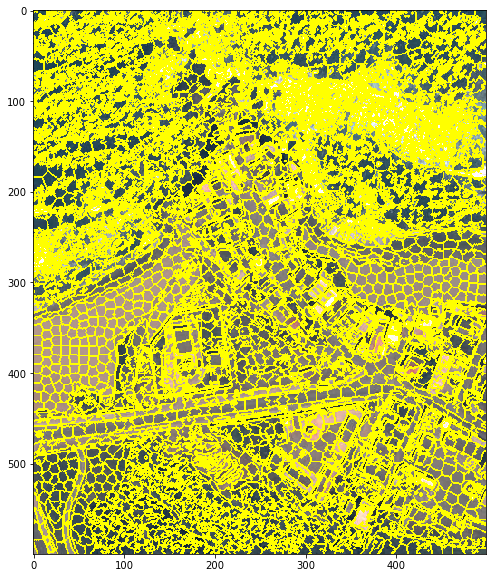

In [25]:
cv_slic = cv2.ximgproc.createSuperpixelSLIC(original_image, algorithm = cv2.ximgproc.SLIC,
                                            region_size = 10)
cv_slic.iterate(100)
cv_slic_N = cv_slic.getNumberOfSuperpixels()
segments = cv_slic.getLabels()

plt.figure(figsize=(20,10))
plt.imshow(mark_boundaries(image_false_color, segments))

## Merging segments using Canberra distance

In [45]:
th = 0.99
merged_segments = mergeNeighbor(original_image, segments, th)

merging stage = 0
merging stage = 1
merging stage = 2
merging stage = 3
merging stage = 4
merging stage = 5
merging stage = 6
merging stage = 7
merging stage = 8
merging stage = 9
merging stage = 10


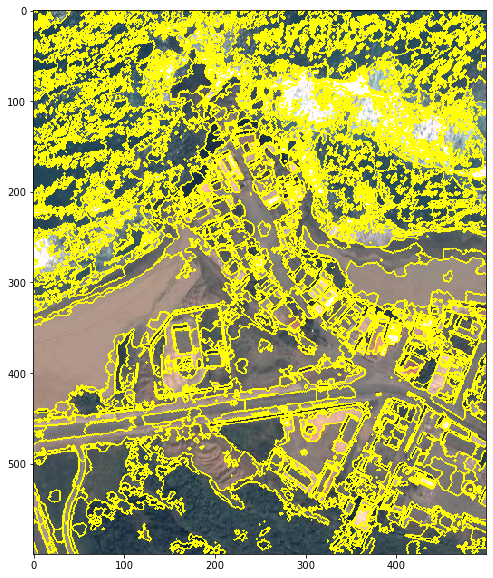

In [46]:
plt.figure(figsize=(20,10))
plt.imshow(mark_boundaries(image_false_color, merged_segments))

# SVM classification

## Numerical results

In [47]:
svm_model = SVC(kernel='rbf', C=200, gamma=2)
denom = 24

## original spectral features
X_tr, y_tr, X_ts, y_ts = get_svm_train_test_data_50_50(original_image/255.0, mask, denom)
svm_model.fit(X_tr, y_tr)
y_pred_OF = svm_model.predict(X_ts)
acc_OF_dict = accuracy_report(y_ts, y_pred_OF)
acc_all = pd.DataFrame(data=acc_OF_dict.values(), columns=["OF (%)"], index=acc_OF_dict.keys())

## fusion of original spectral features and Haralick features from SLIC segmentation
H_properties=['contrast', 'correlation', 'energy', 'homogeneity']
H_features_SLIC = H_features_calc(original_image, segments, H_properties)
SLIC_HF_OF_image = np.concatenate((original_image/255.0, H_features_SLIC),axis=-1 )
X_tr_slic_of, _, X_ts_slic_of, _ = get_svm_train_test_data_50_50(SLIC_HF_OF_image, mask, denom)
svm_model.fit(X_tr_slic_of, y_tr)
y_pred_OF_HF_SLIC = svm_model.predict(X_ts_slic_of)
acc_OF_HF_SLIC_dict = accuracy_report(y_ts, y_pred_OF_HF_SLIC)
acc_all["SLIC (%)"] = acc_OF_HF_SLIC_dict.values()

## fusion of orginal spectral features and Haralick features from merged SLIC segmentation
H_features_merged = H_features_calc(original_image, merged_segments, H_properties)
merged_HF_OF_image = np.concatenate((original_image/255.0, H_features_merged),axis=-1 )
X_tr_merged_of, _, X_ts_merged_of, _ = get_svm_train_test_data_50_50(merged_HF_OF_image, mask, denom)
svm_model.fit(X_tr_merged_of, y_tr)
y_pred_OF_HF_merged = svm_model.predict(X_ts_merged_of)
acc_OF_HF_merged_dict = accuracy_report(y_ts, y_pred_OF_HF_merged)
acc_all["merged SLIC (%)"] = acc_OF_HF_merged_dict.values()

acc_all

,OF (%),SLIC (%),merged SLIC (%)
class 1,83.997566,91.785823,92.120475
class 2,71.074380,81.621409,83.274301
class 3,81.407035,94.095477,91.206030
class 4,84.003386,89.462548,89.420229
class 5,71.438309,90.320382,92.229039
class 6,41.662169,68.375607,65.569347
class 7,83.443709,82.376748,85.430464
class 8,55.960888,69.875893,69.838285
class 9,79.589552,94.029851,94.552239
class 10,51.274945,68.902439,66.019956


## Visual results

In [ ]:
image = original_image/255.0
## original spectral features
X_ts_map_OF = np.reshape(image, (image.shape[0]*image.shape[1], image.shape[2]))
svm_model.fit(X_tr, y_tr)
y_pred_map_OF = svm_model.predict(X_ts_map_OF)
map_OF = np.reshape(y_pred_map_OF, (image.shape[0], image.shape[1]))
map_rgb_OF = labels2rgb(map_OF)

## fusion of original spectral features and morphological opening features
X_ts_map_OF_SLIC_HF= np.reshape(SLIC_HF_OF_image, 
                                (SLIC_HF_OF_image.shape[0]*SLIC_HF_OF_image.shape[1], 
                                 SLIC_HF_OF_image.shape[2]))
svm_model.fit(X_tr_slic_of, y_tr)
y_pred_map_OF_SLIC_HF= svm_model.predict(X_ts_map_OF_SLIC_HF)
map_OF_SLIC_HF= np.reshape(y_pred_map_OF_SLIC_HF, (image.shape[0], image.shape[1]))
map_rgb_OF_SLIC_HF= labels2rgb(map_OF_SLIC_HF)

## fusion of original spectral features and morphological opening features
X_ts_map_OF_merged_HF = np.reshape(merged_HF_OF_image, 
                                   (merged_HF_OF_image.shape[0]*merged_HF_OF_image.shape[1], 
                                    merged_HF_OF_image.shape[2]))
svm_model.fit(X_tr_merged_of, y_tr)
y_pred_map_OF_merged_HF = svm_model.predict(X_ts_map_OF_merged_HF)
map_OF_merged_HF = np.reshape(y_pred_map_OF_merged_HF, (image.shape[0], image.shape[1]))
map_rgb_OF_merged_HF = labels2rgb(map_OF_merged_HF)

In [ ]:
## Area 1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(map_rgb_OF[:300, :250,:])
ax1.set_title("Original Spectral Features")
ax2.imshow(map_rgb_OF_MO[:300, :250,:])
ax2.set_title("SLIC HF")
ax3.imshow(map_rgb_OF_PSO_Bh[:300, :250,:])
ax3.set_title("merged SLIC HF")
ax4.imshow(image[:300, :250,:])
ax4.set_title("false color image data")
plt.title('SVM prediction of Area 1 using different features')
plt.show()

## Area 2
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(map_rgb_OF[:300, 250:,:])
ax1.set_title("Original Spectral Features")
ax2.imshow(map_rgb_OF_MO[:300, 250:,:])
ax2.set_title("SLIC HF")
ax3.imshow(map_rgb_OF_PSO_Bh[:300, 250:,:])
ax3.set_title("merged SLIC HF")
ax4.imshow(image[:300, 250:,:])
ax4.set_title("false color image data")
plt.title('SVM prediction of Area 2 using different features')
plt.show()

## Area 3
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(map_rgb_OF[300:, :250,:])
ax1.set_title("Original Spectral Features")
ax2.imshow(map_rgb_OF_MO[300:, :250,:])
ax2.set_title("SLIC HF")
ax3.imshow(map_rgb_OF_PSO_Bh[300:, :250,:])
ax3.set_title("merged SLIC HF")
ax4.imshow(image[300:, :250,:])
ax4.set_title("false color image data")
plt.title('SVM prediction of Area 3 using different features')
plt.show()

## Area 4
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(map_rgb_OF[300:, 250:,:])
ax1.set_title("Original Spectral Features")
ax2.imshow(map_rgb_OF_MO[300:, 250:,:])
ax2.set_title("SLIC HF")
ax3.imshow(map_rgb_OF_PSO_Bh[300:, 250:,:])
ax3.set_title("merged SLIC HF")
ax4.imshow(image[300:, 250:,:])
ax4.set_title("false color image data")
plt.title('SVM prediction of Area 3 using different features')
plt.show()